# Tutorial: Creating Your First QA Pipeline with Retrieval-Augmentation

- **Level**: Beginner
- **Time to complete**: 10 minutes
- **Components Used**: [`InMemoryDocumentStore`](https://docs.haystack.deepset.ai/docs/inmemorydocumentstore), [`SentenceTransformersDocumentEmbedder`](https://docs.haystack.deepset.ai/docs/sentencetransformersdocumentembedder), [`SentenceTransformersTextEmbedder`](https://docs.haystack.deepset.ai/docs/sentencetransformerstextembedder), [`InMemoryEmbeddingRetriever`](https://docs.haystack.deepset.ai/docs/inmemoryembeddingretriever), [`PromptBuilder`](https://docs.haystack.deepset.ai/docs/promptbuilder), [`OpenAIGenerator`](https://docs.haystack.deepset.ai/docs/openaigenerator)
- **Prerequisites**: You must have an [OpenAI API Key](https://platform.openai.com/api-keys).
- **Goal**: After completing this tutorial, you'll have learned the new prompt syntax and how to use PromptBuilder and OpenAIGenerator to build a generative question-answering pipeline with retrieval-augmentation.

> This tutorial uses Haystack 2.0. To learn more, read the [Haystack 2.0 announcement](https://haystack.deepset.ai/blog/haystack-2-release) or visit the [Haystack 2.0 Documentation](https://docs.haystack.deepset.ai/docs/intro).

## Overview

This tutorial shows you how to create a generative question-answering pipeline using the retrieval-augmentation ([RAG](https://www.deepset.ai/blog/llms-retrieval-augmentation)) approach with Haystack 2.0. The process involves four main components: [SentenceTransformersTextEmbedder](https://docs.haystack.deepset.ai/docs/sentencetransformerstextembedder) for creating an embedding for the user query, [InMemoryBM25Retriever](https://docs.haystack.deepset.ai/docs/inmemorybm25retriever) for fetching relevant documents, [PromptBuilder](https://docs.haystack.deepset.ai/docs/promptbuilder) for creating a template prompt, and [OpenAIGenerator](https://docs.haystack.deepset.ai/docs/openaigenerator) for generating responses.

For this tutorial, you'll use the Wikipedia pages of [Seven Wonders of the Ancient World](https://en.wikipedia.org/wiki/Wonders_of_the_World) as Documents, but you can replace them with any text you want.


## Preparing the Colab Environment

- [Enable GPU Runtime in Colab](https://docs.haystack.deepset.ai/docs/enabling-gpu-acceleration)
- [Set logging level to INFO](https://docs.haystack.deepset.ai/docs/logging)

## Installing Haystack

Install Haystack 2.0 and other required packages with `pip`:

In [ ]:
%%bash

pip install haystack-ai
pip install "datasets>=2.6.1"
pip install "sentence-transformers>=3.0.0"

### Enabling Telemetry

Knowing you're using this tutorial helps us decide where to invest our efforts to build a better product but you can always opt out by commenting the following line. See [Telemetry](https://docs.haystack.deepset.ai/docs/enabling-telemetry) for more details.

In [ ]:
from haystack.telemetry import tutorial_running

tutorial_running(27)

## Fetching and Indexing Documents

You'll start creating your question answering system by downloading the data and indexing the data with its embeddings to a DocumentStore.

In this tutorial, you will take a simple approach to writing documents and their embeddings into the DocumentStore. For a full indexing pipeline with preprocessing, cleaning and splitting, check out our tutorial on [Preprocessing Different File Types](https://haystack.deepset.ai/tutorials/30_file_type_preprocessing_index_pipeline).


### Initializing the DocumentStore

Initialize a DocumentStore to index your documents. A DocumentStore stores the Documents that the question answering system uses to find answers to your questions. In this tutorial, you'll be using the `InMemoryDocumentStore`.

In [ ]:
from haystack.document_stores.in_memory import InMemoryDocumentStore

document_store = InMemoryDocumentStore()

> `InMemoryDocumentStore` is the simplest DocumentStore to get started with. It requires no external dependencies and it's a good option for smaller projects and debugging. But it doesn't scale up so well to larger Document collections, so it's not a good choice for production systems. To learn more about the different types of external databases that Haystack supports, see [DocumentStore Integrations](https://haystack.deepset.ai/integrations?type=Document+Store).

The DocumentStore is now ready. Now it's time to fill it with some Documents.

### Fetch the Data

You'll use the Wikipedia pages of [Seven Wonders of the Ancient World](https://en.wikipedia.org/wiki/Wonders_of_the_World) as Documents. We preprocessed the data and uploaded to a Hugging Face Space: [Seven Wonders](https://huggingface.co/datasets/bilgeyucel/seven-wonders). Thus, you don't need to perform any additional cleaning or splitting.

Fetch the data and convert it into Haystack Documents:

In [ ]:
from datasets import load_dataset
from haystack import Document

dataset = load_dataset("bilgeyucel/seven-wonders", split="train")
docs = [Document(content=doc["content"], meta=doc["meta"]) for doc in dataset]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Initalize a Document Embedder

To store your data in the DocumentStore with embeddings, initialize a [SentenceTransformersDocumentEmbedder](https://docs.haystack.deepset.ai/docs/sentencetransformersdocumentembedder) with the model name and call `warm_up()` to download the embedding model.

> If you'd like, you can use a different [Embedder](https://docs.haystack.deepset.ai/docs/embedders) for your documents.

In [ ]:
from haystack.components.embedders import SentenceTransformersDocumentEmbedder

doc_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
doc_embedder.warm_up()

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


### Write Documents to the DocumentStore

Run the `doc_embedder` with the Documents. The embedder will create embeddings for each document and save these embeddings in Document object's `embedding` field. Then, you can write the Documents to the DocumentStore with `write_documents()` method.

In [ ]:
docs_with_embeddings = doc_embedder.run(docs)
document_store.write_documents(docs_with_embeddings["documents"])

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

151

## Building the RAG Pipeline

The next step is to build a [Pipeline](https://docs.haystack.deepset.ai/docs/pipelines) to generate answers for the user query following the RAG approach. To create the pipeline, you first need to initialize each component, add them to your pipeline, and connect them.

### Initialize a Text Embedder

Initialize a text embedder to create an embedding for the user query. The created embedding will later be used by the Retriever to retrieve relevant documents from the DocumentStore.

> ⚠️ Notice that you used `sentence-transformers/all-MiniLM-L6-v2` model to create embeddings for your documents before. This is why you need to use the same model to embed the user queries.

In [ ]:
from haystack.components.embedders import SentenceTransformersTextEmbedder

text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")

### Initialize the Retriever

Initialize a [InMemoryEmbeddingRetriever](https://docs.haystack.deepset.ai/docs/inmemoryembeddingretriever) and make it use the InMemoryDocumentStore you initialized earlier in this tutorial. This Retriever will get the relevant documents to the query.

In [ ]:
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever

retriever = InMemoryEmbeddingRetriever(document_store)

### Define a Template Prompt

Create a custom prompt for a generative question answering task using the RAG approach. The prompt should take in two parameters: `documents`, which are retrieved from a document store, and a `question` from the user. Use the Jinja2 looping syntax to combine the content of the retrieved documents in the prompt.

Next, initialize a [PromptBuilder](https://docs.haystack.deepset.ai/docs/promptbuilder) instance with your prompt template. The PromptBuilder, when given the necessary values, will automatically fill in the variable values and generate a complete prompt. This approach allows for a more tailored and effective question-answering experience.

In [ ]:
from haystack.components.builders import PromptBuilder

template = """
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

prompt_builder = PromptBuilder(template=template)

### Initialize a Generator


Generators are the components that interact with large language models (LLMs). Now, set `OPENAI_API_KEY` environment variable and initialize a [OpenAIGenerator](https://docs.haystack.deepset.ai/docs/OpenAIGenerator) that can communicate with OpenAI GPT models. As you initialize, provide a model name:

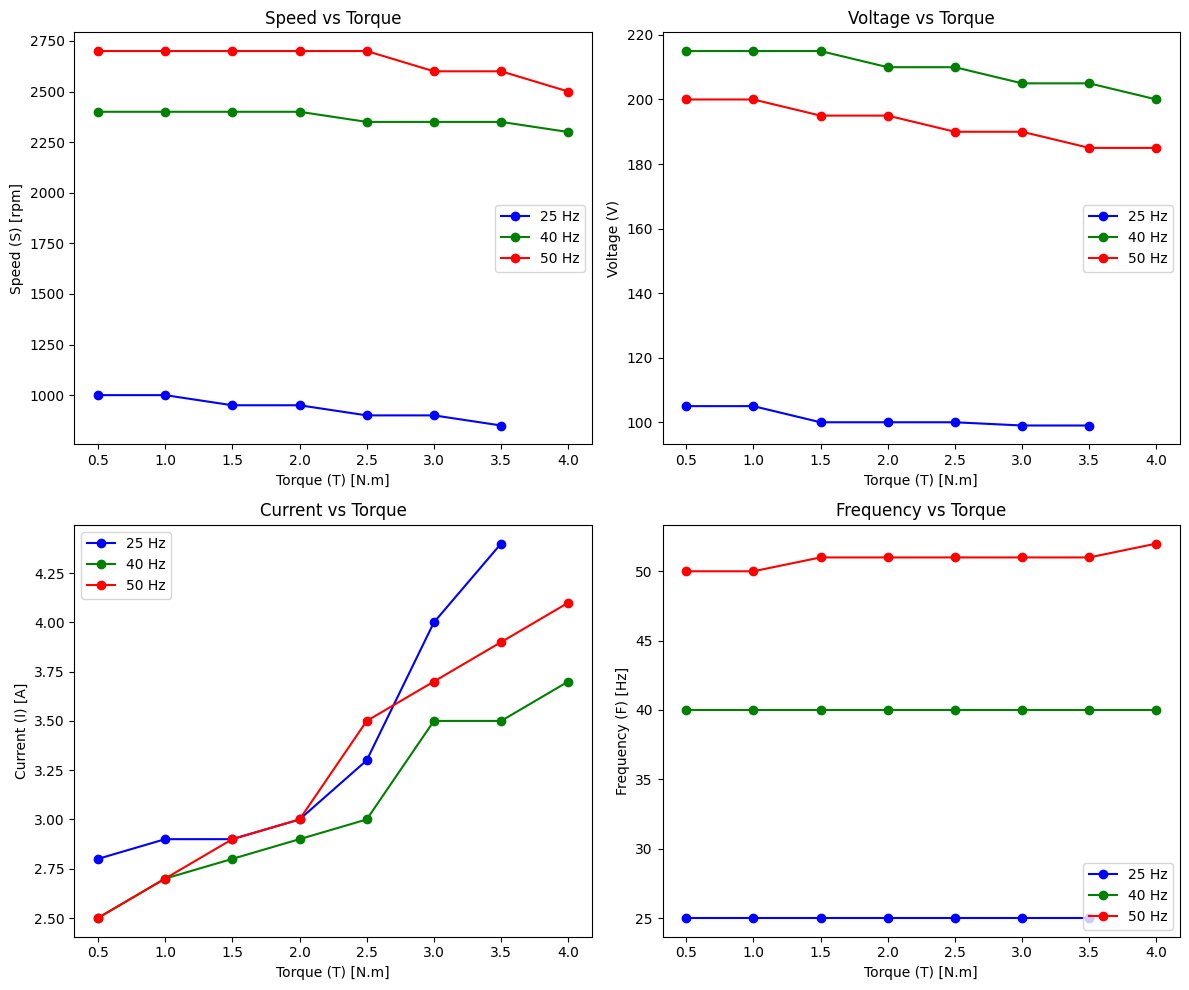

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the tables
T_25Hz = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0])
F_25Hz = np.array([25, 25, 25, 25, 25, 25, 25, np.nan])  # Frequency (Hz)
S_25Hz = np.array([1000, 1000, 950, 950, 900, 900, 850, np.nan])  # Speed (rpm)
V_25Hz = np.array([105, 105, 100, 100, 100, 99, 99, np.nan])  # Voltage (V)
I_25Hz = np.array([2.8, 2.9, 2.9, 3.0, 3.3, 4.0, 4.4, np.nan])  # Current (A)

T_40Hz = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0])
F_40Hz = np.array([40, 40, 40, 40, 40, 40, 40, 40])  # Frequency (Hz)
S_40Hz = np.array([2400, 2400, 2400, 2400, 2350, 2350, 2350, 2300])  # Speed (rpm)
V_40Hz = np.array([215, 215, 215, 210, 210, 205, 205, 200])  # Voltage (V)
I_40Hz = np.array([2.5, 2.7, 2.8, 2.9, 3.0, 3.5, 3.5, 3.7])  # Current (A)

T_50Hz = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0])
F_50Hz = np.array([50, 50, 51, 51, 51, 51, 51, 52])  # Frequency (Hz)
S_50Hz = np.array([2700, 2700, 2700, 2700, 2700, 2600, 2600, 2500])  # Speed (rpm)
V_50Hz = np.array([200, 200, 195, 195, 190, 190, 185, 185])  # Voltage (V)
I_50Hz = np.array([2.5, 2.7, 2.9, 3.0, 3.5, 3.7, 3.9, 4.1])  # Current (A)

# Plotting
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Plot for Speed vs Torque
ax[0, 0].plot(T_25Hz, S_25Hz, label="25 Hz", marker='o', linestyle='-', color='b')
ax[0, 0].plot(T_40Hz, S_40Hz, label="40 Hz", marker='o', linestyle='-', color='g')
ax[0, 0].plot(T_50Hz, S_50Hz, label="50 Hz", marker='o', linestyle='-', color='r')
ax[0, 0].set_xlabel("Torque (T) [N.m]")
ax[0, 0].set_ylabel("Speed (S) [rpm]")
ax[0, 0].set_title("Speed vs Torque")
ax[0, 0].legend()

# Plot for Voltage vs Torque
ax[0, 1].plot(T_25Hz, V_25Hz, label="25 Hz", marker='o', linestyle='-', color='b')
ax[0, 1].plot(T_40Hz, V_40Hz, label="40 Hz", marker='o', linestyle='-', color='g')
ax[0, 1].plot(T_50Hz, V_50Hz, label="50 Hz", marker='o', linestyle='-', color='r')
ax[0, 1].set_xlabel("Torque (T) [N.m]")
ax[0, 1].set_ylabel("Voltage (V)")
ax[0, 1].set_title("Voltage vs Torque")
ax[0, 1].legend()

# Plot for Current vs Torque
ax[1, 0].plot(T_25Hz, I_25Hz, label="25 Hz", marker='o', linestyle='-', color='b')
ax[1, 0].plot(T_40Hz, I_40Hz, label="40 Hz", marker='o', linestyle='-', color='g')
ax[1, 0].plot(T_50Hz, I_50Hz, label="50 Hz", marker='o', linestyle='-', color='r')
ax[1, 0].set_xlabel("Torque (T) [N.m]")
ax[1, 0].set_ylabel("Current (I) [A]")
ax[1, 0].set_title("Current vs Torque")
ax[1, 0].legend()

# Plot for Frequency vs Torque (optional, since F is constant for some)
ax[1, 1].plot(T_25Hz, F_25Hz, label="25 Hz", marker='o', linestyle='-', color='b')
ax[1, 1].plot(T_40Hz, F_40Hz, label="40 Hz", marker='o', linestyle='-', color='g')
ax[1, 1].plot(T_50Hz, F_50Hz, label="50 Hz", marker='o', linestyle='-', color='r')
ax[1, 1].set_xlabel("Torque (T) [N.m]")
ax[1, 1].set_ylabel("Frequency (F) [Hz]")
ax[1, 1].set_title("Frequency vs Torque")
ax[1, 1].legend()

plt.tight_layout()
plt.show()


> You can replace `OpenAIGenerator` in your pipeline with another `Generator`. Check out the full list of generators [here](https://docs.haystack.deepset.ai/docs/generators).

### Build the Pipeline

To build a pipeline, add all components to your pipeline and connect them. Create connections from `text_embedder`'s "embedding" output to "query_embedding" input of `retriever`, from `retriever` to `prompt_builder` and from `prompt_builder` to `llm`. Explicitly connect the output of `retriever` with "documents" input of the `prompt_builder` to make the connection obvious as `prompt_builder` has two inputs ("documents" and "question").

For more information on pipelines and creating connections, refer to [Creating Pipelines](https://docs.haystack.deepset.ai/docs/creating-pipelines) documentation.

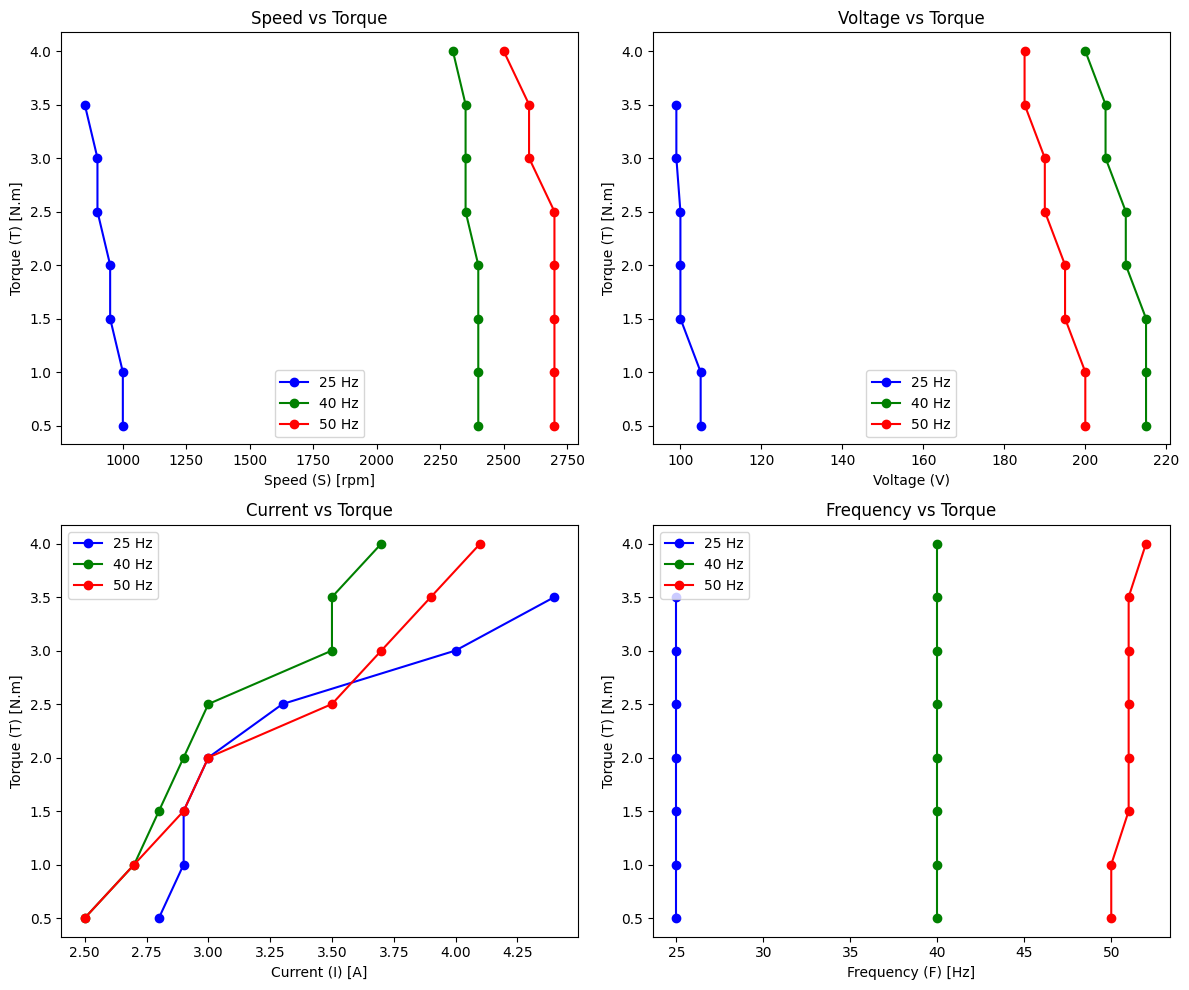

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the tables
T_25Hz = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0])
F_25Hz = np.array([25, 25, 25, 25, 25, 25, 25, np.nan])  # Frequency (Hz)
S_25Hz = np.array([1000, 1000, 950, 950, 900, 900, 850, np.nan])  # Speed (rpm)
V_25Hz = np.array([105, 105, 100, 100, 100, 99, 99, np.nan])  # Voltage (V)
I_25Hz = np.array([2.8, 2.9, 2.9, 3.0, 3.3, 4.0, 4.4, np.nan])  # Current (A)

T_40Hz = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0])
F_40Hz = np.array([40, 40, 40, 40, 40, 40, 40, 40])  # Frequency (Hz)
S_40Hz = np.array([2400, 2400, 2400, 2400, 2350, 2350, 2350, 2300])  # Speed (rpm)
V_40Hz = np.array([215, 215, 215, 210, 210, 205, 205, 200])  # Voltage (V)
I_40Hz = np.array([2.5, 2.7, 2.8, 2.9, 3.0, 3.5, 3.5, 3.7])  # Current (A)

T_50Hz = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0])
F_50Hz = np.array([50, 50, 51, 51, 51, 51, 51, 52])  # Frequency (Hz)
S_50Hz = np.array([2700, 2700, 2700, 2700, 2700, 2600, 2600, 2500])  # Speed (rpm)
V_50Hz = np.array([200, 200, 195, 195, 190, 190, 185, 185])  # Voltage (V)
I_50Hz = np.array([2.5, 2.7, 2.9, 3.0, 3.5, 3.7, 3.9, 4.1])  # Current (A)

# Plotting
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Plot for Speed vs Torque (Torque on y-axis)
ax[0, 0].plot(S_25Hz, T_25Hz, label="25 Hz", marker='o', linestyle='-', color='b')
ax[0, 0].plot(S_40Hz, T_40Hz, label="40 Hz", marker='o', linestyle='-', color='g')
ax[0, 0].plot(S_50Hz, T_50Hz, label="50 Hz", marker='o', linestyle='-', color='r')
ax[0, 0].set_xlabel("Speed (S) [rpm]")
ax[0, 0].set_ylabel("Torque (T) [N.m]")
ax[0, 0].set_title("Speed vs Torque")
ax[0, 0].legend()

# Plot for Voltage vs Torque (Torque on y-axis)
ax[0, 1].plot(V_25Hz, T_25Hz, label="25 Hz", marker='o', linestyle='-', color='b')
ax[0, 1].plot(V_40Hz, T_40Hz, label="40 Hz", marker='o', linestyle='-', color='g')
ax[0, 1].plot(V_50Hz, T_50Hz, label="50 Hz", marker='o', linestyle='-', color='r')
ax[0, 1].set_xlabel("Voltage (V)")
ax[0, 1].set_ylabel("Torque (T) [N.m]")
ax[0, 1].set_title("Voltage vs Torque")
ax[0, 1].legend()

# Plot for Current vs Torque (Torque on y-axis)
ax[1, 0].plot(I_25Hz, T_25Hz, label="25 Hz", marker='o', linestyle='-', color='b')
ax[1, 0].plot(I_40Hz, T_40Hz, label="40 Hz", marker='o', linestyle='-', color='g')
ax[1, 0].plot(I_50Hz, T_50Hz, label="50 Hz", marker='o', linestyle='-', color='r')
ax[1, 0].set_xlabel("Current (I) [A]")
ax[1, 0].set_ylabel("Torque (T) [N.m]")
ax[1, 0].set_title("Current vs Torque")
ax[1, 0].legend()

# Plot for Frequency vs Torque (Torque on y-axis)
ax[1, 1].plot(F_25Hz, T_25Hz, label="25 Hz", marker='o', linestyle='-', color='b')
ax[1, 1].plot(F_40Hz, T_40Hz, label="40 Hz", marker='o', linestyle='-', color='g')
ax[1, 1].plot(F_50Hz, T_50Hz, label="50 Hz", marker='o', linestyle='-', color='r')
ax[1, 1].set_xlabel("Frequency (F) [Hz]")
ax[1, 1].set_ylabel("Torque (T) [N.m]")
ax[1, 1].set_title("Frequency vs Torque")
ax[1, 1].legend()

plt.tight_layout()
plt.show()


That's it! Your RAG pipeline is ready to generate answers to questions!

## Asking a Question

When asking a question, use the `run()` method of the pipeline. Make sure to provide the question to both the `text_embedder` and the `prompt_builder`. This ensures that the `{{question}}` variable in the template prompt gets replaced with your specific question.

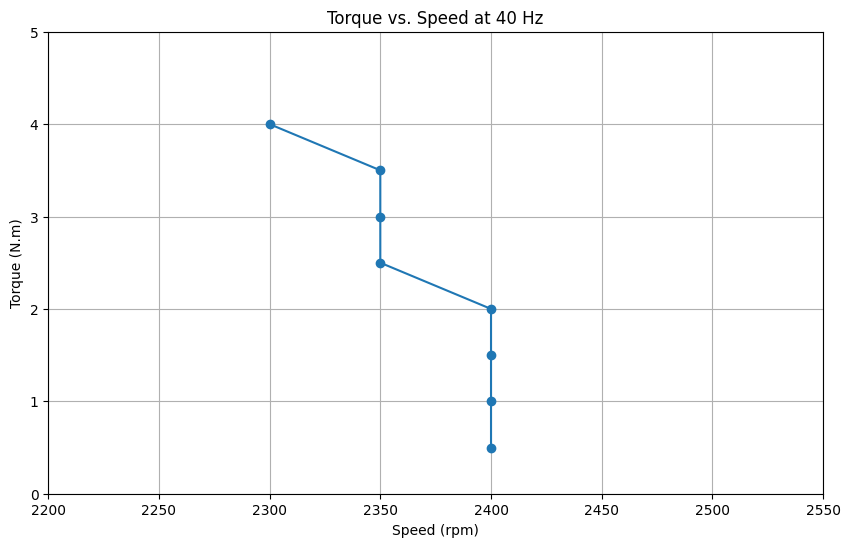

In [3]:
import matplotlib.pyplot as plt

# Data
torque = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
speed = [2400, 2400, 2400, 2400, 2350, 2350, 2350, 2300]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(speed, torque, marker='o')
plt.title('Torque vs. Speed at 40 Hz')
plt.xlabel('Speed (rpm)')
plt.ylabel('Torque (N.m)')
plt.grid()
plt.xlim(2200, 2500)
plt.ylim(0, 5)
plt.xticks(range(2200, 2600, 50))
plt.yticks(range(0, 6))
plt.show()

Here are some other example questions to test:

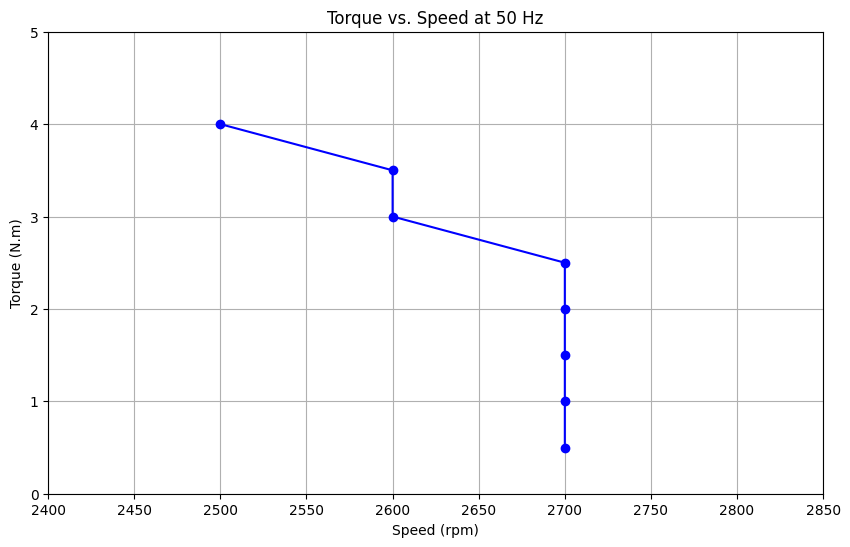

In [4]:
import matplotlib.pyplot as plt

# Data
torque = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
speed = [2700, 2700, 2700, 2700, 2700, 2600, 2600, 2500]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(speed, torque, marker='o', color='blue')
plt.title('Torque vs. Speed at 50 Hz')
plt.xlabel('Speed (rpm)')
plt.ylabel('Torque (N.m)')
plt.grid()
plt.xlim(2400, 2800)
plt.ylim(0, 5)
plt.xticks(range(2400, 2900, 50))
plt.yticks(range(0, 6))
plt.show()

## What's next

🎉 Congratulations! You've learned how to create a generative QA system for your documents with the RAG approach.

If you liked this tutorial, you may also enjoy:
- [Filtering Documents with Metadata](https://haystack.deepset.ai/tutorials/31_metadata_filtering)
- [Preprocessing Different File Types](https://haystack.deepset.ai/tutorials/30_file_type_preprocessing_index_pipeline)
- [Creating a Hybrid Retrieval Pipeline](https://haystack.deepset.ai/tutorials/33_hybrid_retrieval)

To stay up to date on the latest Haystack developments, you can [subscribe to our newsletter](https://landing.deepset.ai/haystack-community-updates) and [join Haystack discord community](https://discord.gg/haystack).

Thanks for reading!